In [14]:
import os

import jax
import jax.numpy as jnp
import jax.random as jrand

import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_1743208/2073518734.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


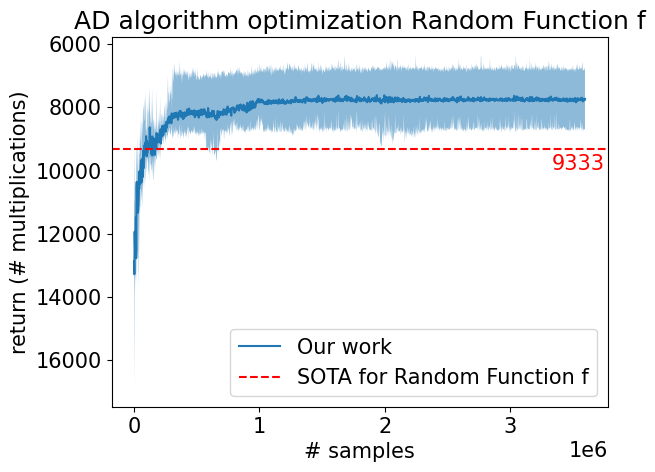

In [35]:
font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 15}

plt.rc("font", **font)

path = "PPO_data/" # "A0_data/" # 
l = 1500 # 4000

runs = []
for file in os.listdir(path=os.path.join(os.getcwd(), path)):
				if file.endswith(".csv"):
								data = np.genfromtxt(os.path.join(os.getcwd(), path, file), delimiter=",", skip_header=1)
								num_samples = data[:l, 0]*32*75
								num_muls = data[:l, 1]
								runs.append(num_muls)

data = jnp.stack(runs, axis=0)

data_mean = jnp.mean(data, axis=0)
data_max = jnp.max(data, axis=0)
data_min	= jnp.min(data, axis=0)
data_err = jnp.stack([data_min, data_max], axis=0)

fig, ax = plt.subplots()
ax.plot(num_samples, data_mean, label="Our work")
ax.fill_between(num_samples, data_min, data_max, alpha=0.5)
ax.axhline(y=-9333., color="r", linestyle="--", label="SOTA for Random Function f")
ax.annotate("9333", (num_samples[-1], -9333), textcoords="offset points", xytext=(-5, -15), ha="center", color="red")
ax.set_xlabel("# samples")
ax.set_ylabel("return (# multiplications)")

ax.set_title("AD algorithm optimization Random Function f")

ticks = ax.get_yticks()
labels = ax.get_yticklabels()
labels = [str(int(-t)) for t in ticks]
ax.set_yticklabels(labels)

ax.legend(loc="lower right")

In [48]:
from typing import Callable, Sequence
from chex import Array
from timeit import default_timer as timer
from tqdm import tqdm
import seaborn	as sns

from graphax import jacve

def measure_execution_time(f: Callable, 
                            args: Sequence[Array], 
                            order,
                            samplesize: int = 1000, 
                            print_results: bool = False,
                            use_vmap: bool = True) -> Sequence[int]:
    """
    TODO docstring
    """
    measurements = []
    argnums = list(range(len(args)))
    
    grad_f = jax.jit(jax.vmap(jacve(f, order=order, argnums=argnums)))

    def measure(xs):
        st = timer()
        out = grad_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
               
    measurements = [measure(args)*1000 for i in tqdm(range(samplesize))]
    if print_results:
        print(measurements)
    
    plot = sns.histplot(measurements[10:], bins=50, stat="probability")
    fig = plot.get_figure()
    fig.savefig("./runtime_distribution.png")
    
    del measure
    del grad_f
    
    # Exclude first measurements due to JIT compilation
    return jnp.array(measurements[10:])

In [49]:
def measure_execution_time_with_jax(f: Callable, 
                                    args: Sequence[Array],
                                    samplesize: int = 1000) -> Sequence[int]:
    """
    TODO docstring
    """
    fwd_measurements, rev_measurements = [], []
    argnums = list(range(len(args)))
    
    fwd_f = jax.jit(jax.vmap(jax.jacfwd(f, argnums=argnums)))
    rev_f = jax.jit(jax.vmap(jax.jacrev(f, argnums=argnums)))
    
    # print(grad_f(*[arg for arg in args]))
    def measure(xs):
        st = timer()
        out = fwd_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    fwd_measurements = [measure(args)*1000 for i in tqdm(range(samplesize))]
    def measure(xs):
        st = timer()
        out = rev_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    rev_measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    
    # Exclude first measurement due to JIT compilation
    return jnp.array(fwd_measurements[10:]), jnp.array(rev_measurements[10:])

In [50]:
def plot_performance(f: Callable,
                    args: Sequence[Array],
                    order, 
                    mM_order,
                    fname: str,
                    samplesize: int = 1000,
                    quantiles: Array = jnp.array([0.025, 0.975]),
                    caption: str ="different modes",
                    use_vmap: bool = True) -> None:
    """
    TODO docstring
    """    
    cc_measurements = measure_execution_time(f, args, order, samplesize=samplesize, use_vmap=use_vmap)
    mM_measurements = measure_execution_time(f, args, mM_order, samplesize=samplesize, use_vmap=use_vmap)
    rev_measurements = measure_execution_time(f, args, "rev", samplesize=samplesize, use_vmap=use_vmap)
    fwd_measurements = measure_execution_time(f, args, "fwd", samplesize=samplesize, use_vmap=use_vmap)
    
    fwd_median = jnp.median(fwd_measurements)
    rev_median = jnp.median(rev_measurements)
    mM_median = jnp.median(mM_measurements)
    cc_median = jnp.median(cc_measurements)
    
    print(f"fwd median: {fwd_median}, rev median: {rev_median}, mM median: {mM_median}, cc median: {cc_median}")
    
    fwd_err = jnp.quantile(fwd_measurements, quantiles) - fwd_median  
    rev_err = jnp.quantile(rev_measurements, quantiles) - rev_median  
    mM_err = jnp.quantile(mM_measurements, quantiles) - mM_median  
    cc_err = jnp.quantile(cc_measurements, quantiles) - cc_median 
    
    print(f"fwd err: {fwd_err}, rev err: {rev_err}, mM err: {mM_err}, cc err: {cc_err}")
    
    fig, ax = plt.subplots()
    
    plt.rcParams.update({"font.size": 14})  
    
    modes = ["forward", "reverse", "Markowitz", "AlphaGrad"]
    x_pos = jnp.arange(0, len(modes))
    runtimes = jnp.stack([fwd_median, rev_median, mM_median, cc_median])
    runtime_errors = jnp.stack([fwd_err, rev_err, mM_err, cc_err], axis=1)*jnp.array([[-1.], [1.]])

    ax.bar(x_pos, runtimes, yerr=runtime_errors, align="center", alpha=0.5, 
            ecolor="black", color="#6096f6", capsize=10)
    
    ax.set_ylabel("Evaluation time [ms]", fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(modes, fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_title(f"Evaluation times of {caption}")
    ax.yaxis.grid(True)  
    # ax.set_ylim((0.025, 0.04))
    
    plt.tight_layout()
    # plt.savefig(fname)
    plt.show()

In [51]:
from graphax import jacve
from graphax.examples import f

In [52]:
# 6374 mults
order = [33, 8, 16, 77, 15, 62, 40, 58, 14, 76, 42, 60, 54, 34, 61, 72, 37, 55, 
         18, 75, 36, 74, 65, 26, 35, 25, 66, 38, 64, 59, 53, 20, 27, 47, 10, 69, 
         23, 11, 41, 79, 9, 7, 12, 63, 71, 24, 67, 51, 4, 1, 21, 3, 6, 2, 49, 
         13, 44, 46, 56, 17, 39, 57, 43, 32, 52, 30, 48, 31, 5, 22, 45, 19, 50, 
         28, 29] 

mM_order = [42, 40, 37, 35, 34, 36, 48, 9, 11, 16, 19, 22, 24, 30, 39, 41, 43, 
            46, 52, 55, 56, 57, 60, 67, 3, 6, 13, 17, 25, 27, 31, 45, 50, 51, 
            59, 49, 29, 63, 66, 69, 71, 75, 77, 79, 4, 10, 18, 20, 1, 5, 53, 62, 
            64, 44, 14, 58, 61, 28, 38, 7, 47, 74, 26, 54, 32, 12, 8, 76, 23, 2, 
            33, 15, 72, 21, 65]

In [20]:
batchsize = 512
key = jrand.PRNGKey(250197)
a = jrand.uniform(key, (batchsize, 4,))
b = jrand.uniform(key, (batchsize, 2, 3))
c = jrand.uniform(key, (batchsize, 4, 4))
d = jrand.uniform(key, (batchsize, 4, 1))
xs = (a, b, c, d)
argnums = list(range(len(xs)))
xs = jax.device_put(xs, jax.devices("cpu")[0])
order = "rev"
grad_f	= jax.jit(jacve(f, order=order, argnums=argnums))
vmap_f = jax.jit(jax.vmap(grad_f))
vmap_f(*xs)
# plot_performance(f, xs, order, mM_order, "./f.png", samplesize=1000, use_vmap=False)

Post: SparseTensor(
   shape = (1,4|1,4),
   out_dims = (SparseDimension(id=0, size=1, val_dim=0, other_id=2), SparseDimension(id=1, size=4, val_dim=1, other_id=3)),
   primal_dims = (SparseDimension(id=2, size=1, val_dim=0, other_id=0), SparseDimension(id=3, size=4, val_dim=1, other_id=1)),
   val = Traced<ShapedArray(float32[1,4])>with<DynamicJaxprTrace(level=3/0)>,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (|),
   out_dims = (),
   primal_dims = (),
   val = None,
   pre_transforms = [JacobianTransform(transform=<function reshape_elemental_rule.<locals>.reshape_transform at 0x7ef51438eef0>, inverse_transform=<function reshape_elemental_rule.<locals>.inverse_reshape_transform at 0x7ef51438ef80>)],
   post_transforms = [])

Post: SparseTensor(
   shape = (4,4|4,4),
   out_dims = (SparseDimension(id=0, size=4, val_dim=None, other_id=3), DenseDimension(id=1, size=4, val_dim=0)),
   primal_dims = (DenseDimension(id=2, size=4, val_dim=1), SparseDimens

((Array([[[[           nan,            nan,            nan,
                       nan],
           [           nan,            nan,            nan,
                       nan],
           [           nan,            nan,            nan,
                       nan],
           [           nan,            nan,            nan,
                       nan]]],
  
  
         [[[ 8.7141962e+00,  2.5144553e-01,  9.5963198e-01,
             1.0960115e+00],
           [-8.9349204e-01, -2.9302480e+00, -1.0717384e+00,
            -8.4006399e-01],
           [ 1.3892579e+00,  4.6027428e-01,  1.9089077e+01,
             2.0725570e+00],
           [ 1.2495880e+03,  4.1303360e+02,  1.5240651e+03,
             8.5285264e+03]]],
  
  
         [[[           nan,            nan,            nan,
                       nan],
           [           nan,            nan,            nan,
                       nan],
           [           nan,            nan,            nan,
                       nan],
     

### Best result so far
fwd mean: 12.422348022460938, rev mean: 11.539432525634766, mM mean: 20.200916290283203, cc mean: 9.115716934204102
fwd err: [-0.25409508  0.66077805], rev err: [-0.2665863   0.14687061], mM err: [-0.30657768  0.2572441 ], cc err: [-0.05720139  0.07864857]

fwd mean: 3.8236873149871826, rev mean: 3.6495230197906494, cc_mean: 2.9825470447540283, mM_mean: 3.825319290161133
fwd std: 0.2087354212999344, rev std: 0.39476415514945984, cc_std: 0.6004145741462708, mM_std: 0.47684094309806824

In [53]:
def plot_performance_over_size_jax(f: Callable,
                                    args: Sequence[Array],
                                    order, 
                                    task: str,
                                    ticks: Sequence[int] = (2, 4, 8),
                                    samplesize: int = 1000,
                                    quantiles = jnp.array([0.025, 0.975])):
    
    cc_medians, cc_errs = [], []
    jax_fwd_medians, jax_fwd_errs = [], []
    jax_rev_medians, jax_rev_errs = [], []
    
    for arg in args:
        cc_measurements = measure_execution_time(f, arg, order, samplesize=samplesize)
        
        jax_fwd_measurements, jax_rev_measurements = measure_execution_time_with_jax(f, arg, samplesize=samplesize)
                
        cc_median = jnp.median(cc_measurements)
        jax_fwd_median = jnp.median(jax_fwd_measurements)
        jax_rev_median = jnp.median(jax_rev_measurements)
        
        cc_medians.append(cc_median)
        jax_fwd_medians.append(jax_fwd_median)
        jax_rev_medians.append(jax_rev_median)
                
        cc_errs.append(jnp.quantile(cc_measurements, quantiles) - cc_median)
        jax_fwd_errs.append(jnp.quantile(jax_fwd_measurements, quantiles) - jax_fwd_median)
        jax_rev_errs.append(jnp.quantile(jax_rev_measurements, quantiles) - jax_rev_median)
        
    _arr = jnp.array([[-1.], [1.]])
    jax_fwd_errs = jnp.stack(jax_fwd_errs, axis=1)*_arr
    jax_rev_errs = jnp.stack(jax_rev_errs, axis=1)*_arr
    cc_errs = jnp.stack(cc_errs, axis=1)*_arr
    
    jax_fwd_medians = jnp.array(jax_fwd_medians)
    jax_rev_medians = jnp.array(jax_rev_medians)
    cc_medians = jnp.array(cc_medians)
    
    font = {"family" : "normal",
												"weight" : "normal",
												"size"   : 15}

    plt.rc("font", **font)
    fig, ax = plt.subplots()
    x_pos = jnp.arange(len(args))
    ax.errorbar(x_pos, jax_fwd_medians, yerr=jax_fwd_errs, label="JAX forward mode",
                fmt='.-', ecolor="black", elinewidth=1, capsize=3)
    ax.errorbar(x_pos, jax_rev_medians, yerr=jax_rev_errs, label="JAX reverse mode",
                fmt='.-', ecolor="black", elinewidth=1, capsize=3)
    
    ax.errorbar(x_pos, cc_medians, yerr=cc_errs, label="Graphax + AlphaGrad", 
                fmt='.-', ecolor="black", elinewidth=1, capsize=3, color="green")
    
    ax.set_yscale("log")
    ax.set_ylabel("Evaluation time in [ms]")
    ax.set_xlabel("Batchsize")
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(s) for s in ticks], fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.set_title(f"{task} evaluation times for different modes and batch sizes")
    ax.legend()
    ax.yaxis.grid(True)
    
    plt.tight_layout()
    plt.show()

  0%|          | 0/110 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_id=0), DenseDimension(id=2, size=2, val_dim=1)),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[16,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (3,2|),
   out_dims = (DenseDimension(id=0, size=3, val_dim=0), DenseDimension(id=1, size=2, val_dim=1)),
   primal_dims = (),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[16,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_

  0%|          | 0/110 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_id=0), DenseDimension(id=2, size=2, val_dim=1)),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[64,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (3,2|),
   out_dims = (DenseDimension(id=0, size=3, val_dim=0), DenseDimension(id=1, size=2, val_dim=1)),
   primal_dims = (),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[64,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_

  0%|          | 0/110 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_id=0), DenseDimension(id=2, size=2, val_dim=1)),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[256,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (3,2|),
   out_dims = (DenseDimension(id=0, size=3, val_dim=0), DenseDimension(id=1, size=2, val_dim=1)),
   primal_dims = (),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[256,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, othe

  0%|          | 0/110 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_id=0), DenseDimension(id=2, size=2, val_dim=1)),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[512,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (3,2|),
   out_dims = (DenseDimension(id=0, size=3, val_dim=0), DenseDimension(id=1, size=2, val_dim=1)),
   primal_dims = (),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[512,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, othe

  0%|          | 0/110 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_id=0), DenseDimension(id=2, size=2, val_dim=1)),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[1024,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (3,2|),
   out_dims = (DenseDimension(id=0, size=3, val_dim=0), DenseDimension(id=1, size=2, val_dim=1)),
   primal_dims = (),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[1024,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, ot

  0%|          | 0/110 [00:00<?, ?it/s]

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, other_id=0), DenseDimension(id=2, size=2, val_dim=1)),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[2048,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Pre: SparseTensor(
   shape = (3,2|),
   out_dims = (DenseDimension(id=0, size=3, val_dim=0), DenseDimension(id=1, size=2, val_dim=1)),
   primal_dims = (),
   val = Traced<ShapedArray(float32[3,2])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[2048,3,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0,
   pre_transforms = [],
   post_transforms = [])

Post: SparseTensor(
   shape = (3|3,2),
   out_dims = (SparseDimension(id=0, size=3, val_dim=0, other_id=1),),
   primal_dims = (SparseDimension(id=1, size=3, val_dim=0, ot

100%|██████████| 110/110 [00:04<00:00, 23.79it/s]


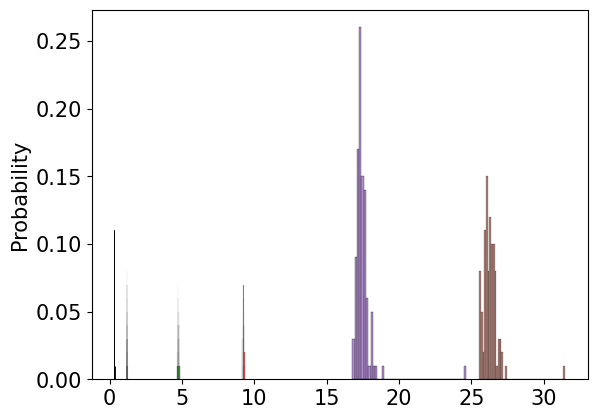

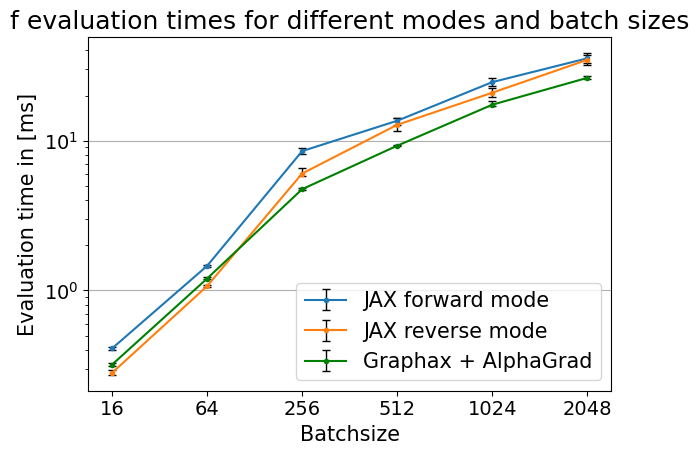

In [55]:
batchsizes = [16, 64, 256, 512, 1024, 2048]
key = jrand.PRNGKey(1234)
xs = []

for batchsize in batchsizes:
				a = jrand.uniform(key, (batchsize, 4,))
				b = jrand.uniform(key, (batchsize, 2, 3))
				c = jrand.uniform(key, (batchsize, 4, 4))
				d = jrand.uniform(key, (batchsize, 4, 1))
				_xs = (a, b, c, d)
				xs.append(_xs)

xs = jax.device_put(xs, jax.devices("cpu")[0])
plot_performance_over_size_jax(f, xs, order, "f", ticks=batchsizes, samplesize=110)